<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Плаксина Елена Константиновна, Levka.

## <center>Обзор библиотеки для генерации временных признаков tsfresh</center>
### <center>Time Series FeatuRe Extraction based on Scalable Hypothesis tests</center>

Библиотека используется для извлечения признаков из временных рядов. Практически все признаки, которые могут прийти вам в голову, уже внесены в расчёт этой библиотеки и нет никакого смысла создавать их самому, когда это можно сделать парой строчек кода из библиотеки.

Извлечённые признаки могут быть использованы для описания или кластеризации временных рядов. Также их можно использовать для задач классификации/регрессии на временных рядах.

<img src="http://tsfresh.readthedocs.io/en/latest/_images/introduction_ts_exa_features.png" width="700" height="600">

### Процесс расчёта признаков состоит из двух этапов:
- Расчёт всех возможных признаков

```python
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")
```
- Отбор релевантных признаков и удаление константных/нулевых признаков

```python
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)  # удаление константных признаков
features_filtered = select_features(extracted_features, y)  # отбор признаков
```

### Процедура отбора признаков
#### Стадия 1
Расчёт признаков
#### Стадия 2
Проверка на значимость каждого признака, расчёт p-value
#### Стадия 3
Поправка на множественную проверку гипотез Бенджамини-Иекутиели

<img src="http://tsfresh.readthedocs.io/en/latest/_images/feature_extraction_process_20160815_mc_1.png" width="700" height="600">

### Приведём пример генерации признаков на основе датасета Human Activity Recognition

In [13]:
import matplotlib.pylab as plt
%matplotlib inline
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

**Загрузка и отрисовка данных**

In [4]:
download_har_dataset()

In [5]:
df = load_har_dataset()

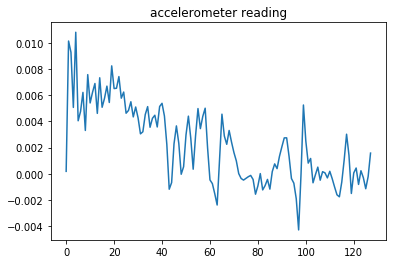

In [12]:
plt.title('accelerometer reading')
plt.plot(df.iloc[0,:])
plt.show()

**Извлечение признаков**

In [14]:
# расчёт только определённого набора параметров, заданного в ComprehensiveFCParameters
extraction_settings = ComprehensiveFCParameters()

In [15]:
# переформируем данные 500 первых показаний сенсоров column-wise, как этого требует формат библиотеки
N = 500
master_df = pd.DataFrame({0: df[:N].values.flatten(),
                          1: np.arange(N).repeat(df.shape[1])})
master_df.head()

,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


In [16]:
X = extract_features(master_df, column_id=1, impute_function=impute, default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████████████████████████████████████| 20/20 [00:34<00:00,  1.74s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__coeff_70__attr_"abs"'


In [18]:
"Число рассчитанных признаков: {}.".format(X.shape[1])

'Число рассчитанных признаков: 794.'

**Обучение классификатора**

In [19]:
y = load_har_classes()[:N]
y.shape

(500,)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [21]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        29
          2       1.00      1.00      1.00         9
          3       1.00      1.00      1.00        14
          4       0.36      0.36      0.36        14
          5       0.26      0.36      0.30        14
          6       0.60      0.45      0.51        20

avg / total       0.73      0.71      0.72       100



**Отберём признаки для каждого класса отдельно и решим задачу бинарной классификации**

In [22]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 5: 216/794


Number of relevant features for class 4: 202/794


Number of relevant features for class 6: 188/794


Number of relevant features for class 1: 216/794


Number of relevant features for class 3: 220/794


Number of relevant features for class 2: 166/794


In [23]:
len(relevant_features)

264

Мы уменьшили количество признаков с 794 до 264.

In [24]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

In [25]:
X_train_filtered.shape, X_test_filtered.shape

((400, 264), (100, 264))

In [26]:
cl = DecisionTreeClassifier()
cl.fit(X_train_filtered, y_train)
print(classification_report(y_test, cl.predict(X_test_filtered)))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        29
          2       1.00      1.00      1.00         9
          3       1.00      1.00      1.00        14
          4       0.27      0.29      0.28        14
          5       0.29      0.36      0.32        14
          6       0.62      0.50      0.56        20

avg / total       0.72      0.71      0.71       100



Качество модели практически не изменилось, однако модель стала намного проще.

**Сравнение с классификатором на стандартных признаках**

In [29]:
X_1 = df.iloc[:N,:]
X_1.shape

(500, 128)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2)

In [31]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.55      0.58      0.56        19
          2       0.69      0.52      0.59        21
          3       0.75      0.46      0.57        13
          4       0.42      0.57      0.48        14
          5       0.65      0.50      0.56        22
          6       0.20      0.36      0.26        11

avg / total       0.57      0.51      0.53       100



Как видимо, качество модели значительно улучшилось по сравнению с наивным классификатором.